# Classification with CNN Model

In [1]:
import os
from pathlib import Path

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

C:\Users\matou\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## PyTorch Dataset and Dataloaders

In [2]:
class ClassificationDataset(Dataset):
    
    def __init__(self, folder, augment=None):
        self.folder = Path(folder)
        self.files = list(self.folder.glob("*.jpg"))
        self.augment = augment

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]

        # ---- Load and preprocess image ----
        image = cv.imread(str(img_path))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.resize(image, IMAGE_SIZE)

        # Albumentations augmentations (if provided)
        if self.augment:
            image = self.augment(image=image)["image"]

        # Convert image to tensor [C, H, W], normalize to [0,1]
        image = image.astype(np.float32) / 255.0
        image_tensor = torch.from_numpy(image).permute(2, 0, 1)

        # ---- Parse class label from filename ----
        # Filename format: image_<id>_<class>.jpg
        class_label = int(img_path.stem.split("_")[-1])
        label_tensor = torch.tensor(class_label, dtype=torch.long)

        return image_tensor, label_tensor

DATASET_ROOT = Path("../data/classification_dataset/")  

train_folder = DATASET_ROOT / "train"
val_folder = DATASET_ROOT / "val"

train_dataset = ClassificationDataset(train_folder)
val_dataset = ClassificationDataset(val_folder)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Train images: {len(train_dataset)}, Validation images: {len(val_dataset)}")


Train images: 101, Validation images: 22


## Classification Model

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers (fewer channels)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.sigmoid = nn.Sigmoid()
        
        # Fully connected layers
        # After two poolings on 256x256 -> feature map = 16 x 64 x 64
        self.fc1 = nn.Linear(16 * 64 * 64, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Convolution + ReLU + Pooling
        x = self.pool(F.relu(self.conv1(x)))  # -> [B, 8, 128, 128]
        x = self.pool(F.relu(self.conv2(x)))  # -> [B, 16, 64, 64]
        
        # Flatten
        x = torch.flatten(x, 1)  # -> [B, 16*64*64]
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return self.sigmoid(x)

# Test the smaller model
model = SimpleCNN()
sample_input = torch.randn(8, 3, 256, 256)  # batch of 8 images
output = model(sample_input)
print("Output shape:", output.shape)  # Expected: [8, 1]


Output shape: torch.Size([8, 1])


## Model training

In [4]:
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.001
IMAGE_SIZE = (256, 256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(DEVICE)
criterion = nn.BCELoss()  # For sigmoid output
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

all_train_loss = []
all_val_loss = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    # ---- TRAIN ----
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        preds = (outputs > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = train_loss / total
    all_train_loss.append(avg_train_loss)
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).int()
            correct += (preds == labels.int()).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    avg_val_loss = val_loss / total
    all_val_loss.append(avg_val_loss)
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.4f}")



Epoch 1/10
Train Loss: 0.9421, Train Accuracy: 0.4158
Val Loss: 0.6677, Val Accuracy: 0.9545

Epoch 2/10
Train Loss: 0.6464, Train Accuracy: 0.6238
Val Loss: 0.6444, Val Accuracy: 0.4545

Epoch 3/10
Train Loss: 0.5317, Train Accuracy: 0.7129
Val Loss: 0.3234, Val Accuracy: 1.0000

Epoch 4/10
Train Loss: 0.2462, Train Accuracy: 1.0000
Val Loss: 0.0787, Val Accuracy: 1.0000

Epoch 5/10
Train Loss: 0.0433, Train Accuracy: 1.0000
Val Loss: 0.0077, Val Accuracy: 1.0000

Epoch 6/10
Train Loss: 0.0038, Train Accuracy: 1.0000
Val Loss: 0.0008, Val Accuracy: 1.0000

Epoch 7/10
Train Loss: 0.0005, Train Accuracy: 1.0000
Val Loss: 0.0001, Val Accuracy: 1.0000

Epoch 8/10
Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000

Epoch 9/10
Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000

Epoch 10/10
Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000


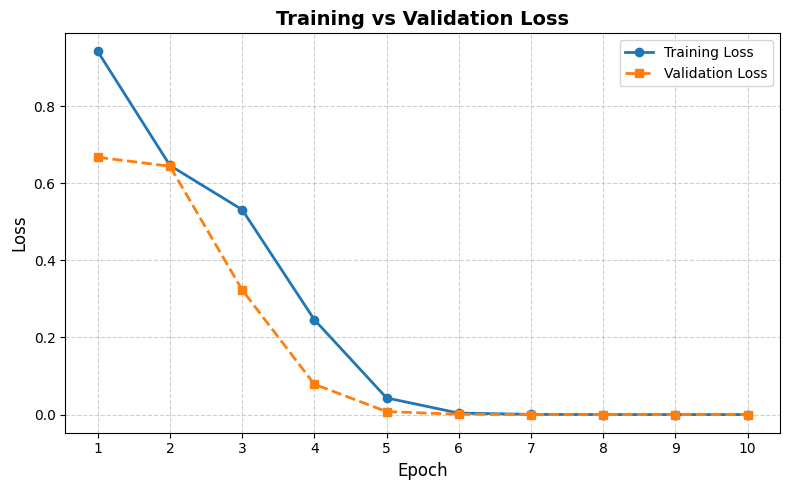

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(all_train_loss, marker='o', linestyle='-', linewidth=2, markersize=6, label='Training Loss')
plt.plot(all_val_loss, marker='s', linestyle='--', linewidth=2, markersize=6, label='Validation Loss')

plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(len(all_val_loss)), [str(i+1) for i in range(len(all_val_loss))])

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()